# Cloud Computing and Data Center design lab: Digital hardware architectures and efficient AI computing schemes - Laboratory 3

Date: 17/05/2024

Student ID: S314215

Student Name: Sadegh Jamishi

# Deep Neural Network compression - laboratory description

In this laboratory, you will learn

- how to perform post-training quantization of a DNN model
- how to perform structured pruning of a DNN model

Solve the tasks reported in the various sections of this notebook. **You are free to use as much cells as you want**, just make sure that the code and text you write is easy to understand. You can show the results with a mix of both code cells (e.g., to generate plots) and markdown cells (to better elaborate on your results).

<br>

---

When you are finished with your notebook, go to _File > Print > Save as pdf_

__N.B. Google Colab may generate a pdf with missing parts.__ If that is the case, download the notebook and print it with a system-local jupyter-notebook, or use an online .ipynb to .pdf converter such as https://www.vertopal.com/en/convert/ipynb-to-pdf

Be sure to check the output file before submitting it!

## Post-training quantization

You are given a model that has been fully trained on MNIST task (description is in mymodel.py, parameters in full_size_model.pt). You are required to load it in the notebook and to quantize it. The model contains 4 layers (fc1, fc2, fc3 and fc4).

    import torch
    from mymodel import SimpleDNN
    fullmodel = torch.load("full_size_model.pt")

To perform the quantization of the weights, access their values, quantize them, and then put them back into the DNN (do you remember how to do this from lab1?)

The quantization operation is

    w = model.fc1.weight                                        # get weights w from layer fc1
    N = 2**l                                                    # define the number of intervals given number of bits l
    delta = 2*q/N                                               # define the size of the quantization interval given half-range q
    wq = torch.clip(delta*torch.round(w/delta), -q, q-delta)    # quantize the weights (and clip the values in the available range!)
    model.fc1.weight.data = wq                                  # put back in the model the quantized weights

where w is the weight matrix. Do this for _all the layers_.

### Task

Load the torch model, then retrieve all the weights and flatten and concatenate them into a single vector to plot a histogram to see their distribution.
Looking at their distribution, you will be able to do some assumptions on the values of the quantization range q.

At this point, quantize the model as described above, and test its accuracy on MNIST. Try different values of q and a different number of bits l and see what happens.

You can plot something to show the results, for example:
- fix the range, and plot the number of bits vs accuracy
- fix the number of bits (use a low number of bits) and plot the range vs accuracy

You can also try to plot the distribution of the quantized weights. What happens?

**Remember to start from a full-precision model each time you quantize it.**

---

N.B. you are _simulating_ the quantization of the DNN: you are still working with float32 within this framework. Because of this you will not see the effects of overflow/underflow or improvements in the inference speed. You will use a saturation approach by using torch.clip, as above.

In [ ]:
!pip install torchvision torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# use transform to convert images to tensors and normalize values with mean 0.5 and standard deviation 0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 49726061.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1844415.76it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12227552.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7019354.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Please note that in the cell below, we defined the device and revised the code to load the data and model onto the specified device, rather than directly onto the GPU. This approach ensures that the model and data are loaded onto the GPU if available, or onto the CPU otherwise.

In [ ]:
# Use this code snippet to test the inference with your quantized models
# N.B. if available, use GPU

import torch
from mymodel import SimpleDNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("full_size_model.pt").to(device) # of course substitute with your quantized model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, (data, targets) in enumerate(test_loader):
        data = data.to(device)
        targets = targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += torch.sum(predicted == targets).item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 98.59%


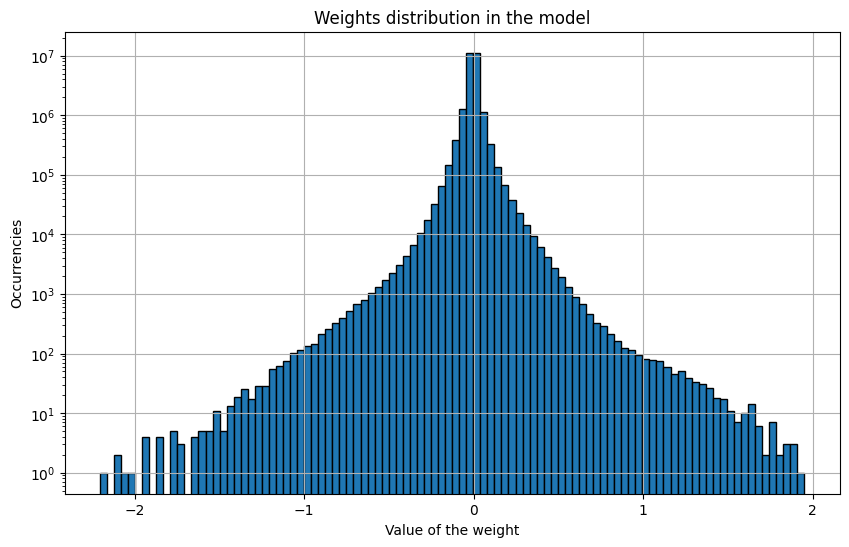

In [ ]:
import matplotlib.pyplot as plt

myweights = torch.concatenate(
[model.fc1.weight.cpu().detach().flatten(),
 model.fc2.weight.cpu().detach().flatten(),
 model.fc3.weight.cpu().detach().flatten(),
 model.fc4.weight.cpu().detach().flatten()]).numpy()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.hist(myweights, bins=100, edgecolor='black')
ax.set_yscale("log")
ax.set_title("Weights distribution in the model")
ax.set_xlabel("Value of the weight")
ax.set_ylabel("Occurrencies")
ax.grid(True)
fig.show()

In [ ]:
len(myweights[(myweights >-1.0) & (myweights <1.0)])/len(myweights)


0.999953513124833

The plot above shows that the majority of weight values range within (-1, 1), indicating that the optimal quantization value is around 1. More than 99.99% of the weights fall within this quantization range.

In [ ]:
from tqdm import tqdm
def quantize_model(model, q, l):
    for param_name, param in model.named_parameters():
        # skip quantizing the biases
        if 'weight' in param_name:
            N = 2**l
            delta = 2 * q / N
            w = param.data
            wq = torch.clip(delta * torch.round(w / delta), -q, q - delta)
            param.data = wq

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += torch.sum(predicted == targets).item()
    accuracy = 100 * correct / total

    return accuracy


def evaluate_quantization(test_loader, q_values, bit_values):
    accuracies = []
    for q in tqdm(q_values, desc='Quantization Range', leave=True):
        #for l in tqdm(bit_values, desc='Number of Bits', leave=True):
        for l in bit_values:
            full_model= torch.load("full_size_model.pt")
            full_model.eval()
            quantize_model(full_model, q, l)
            accuracy = test_model(full_model, test_loader)
            accuracies.append((q, l, accuracy))
            print(f'Quantization - q={q}, bits={l}, Accuracy: {accuracy:.2f}%')
    return accuracies

q_values = [0.5, 0.8, 1.0, 1.2, 1.5, 1.7, 2.0]
bit_values = [2, 4, 8, 12, 16]
accuracies = evaluate_quantization(test_loader, q_values, bit_values)


Quantization Range:   0%|          | 0/7 [00:00<?, ?it/s]

Quantization - q=0.5, bits=2, Accuracy: 11.87%
Quantization - q=0.5, bits=4, Accuracy: 61.97%
Quantization - q=0.5, bits=8, Accuracy: 69.15%
Quantization - q=0.5, bits=12, Accuracy: 69.52%


Quantization Range:  14%|█▍        | 1/7 [01:16<07:39, 76.53s/it]

Quantization - q=0.5, bits=16, Accuracy: 69.56%
Quantization - q=0.8, bits=2, Accuracy: 50.53%
Quantization - q=0.8, bits=4, Accuracy: 85.40%
Quantization - q=0.8, bits=8, Accuracy: 96.15%
Quantization - q=0.8, bits=12, Accuracy: 96.38%


Quantization Range:  29%|██▊       | 2/7 [02:34<06:27, 77.44s/it]

Quantization - q=0.8, bits=16, Accuracy: 96.41%
Quantization - q=1.0, bits=2, Accuracy: 40.91%
Quantization - q=1.0, bits=4, Accuracy: 77.40%
Quantization - q=1.0, bits=8, Accuracy: 98.26%
Quantization - q=1.0, bits=12, Accuracy: 98.25%


Quantization Range:  43%|████▎     | 3/7 [03:56<05:17, 79.27s/it]

Quantization - q=1.0, bits=16, Accuracy: 98.25%
Quantization - q=1.2, bits=2, Accuracy: 19.18%
Quantization - q=1.2, bits=4, Accuracy: 72.49%
Quantization - q=1.2, bits=8, Accuracy: 98.52%
Quantization - q=1.2, bits=12, Accuracy: 98.49%


Quantization Range:  57%|█████▋    | 4/7 [05:15<03:58, 79.50s/it]

Quantization - q=1.2, bits=16, Accuracy: 98.52%
Quantization - q=1.5, bits=2, Accuracy: 19.32%
Quantization - q=1.5, bits=4, Accuracy: 69.74%
Quantization - q=1.5, bits=8, Accuracy: 98.56%
Quantization - q=1.5, bits=12, Accuracy: 98.60%


Quantization Range:  71%|███████▏  | 5/7 [06:33<02:37, 78.76s/it]

Quantization - q=1.5, bits=16, Accuracy: 98.60%
Quantization - q=1.7, bits=2, Accuracy: 19.56%
Quantization - q=1.7, bits=4, Accuracy: 68.22%
Quantization - q=1.7, bits=8, Accuracy: 98.58%
Quantization - q=1.7, bits=12, Accuracy: 98.59%


Quantization Range:  86%|████████▌ | 6/7 [07:51<01:18, 78.59s/it]

Quantization - q=1.7, bits=16, Accuracy: 98.59%
Quantization - q=2.0, bits=2, Accuracy: 10.32%
Quantization - q=2.0, bits=4, Accuracy: 56.23%
Quantization - q=2.0, bits=8, Accuracy: 98.46%
Quantization - q=2.0, bits=12, Accuracy: 98.58%


Quantization Range: 100%|██████████| 7/7 [09:08<00:00, 78.40s/it]

Quantization - q=2.0, bits=16, Accuracy: 98.59%


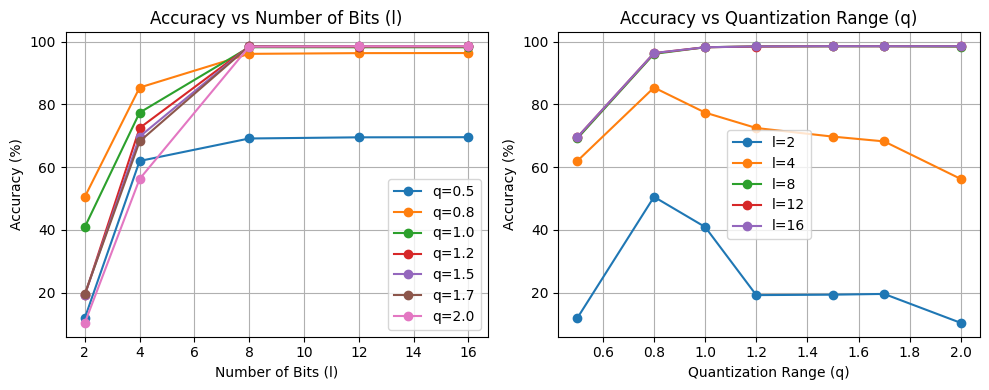

In [ ]:
def plot_accuracy_vs_params(results):
    q_values = sorted(set(q for q, l, acc in results))
    l_values = sorted(set(l for q, l, acc in results))
    l_data = {l_val: ([],[])for l_val in l_values}
    q_data = {q_val: ([],[]) for q_val in q_values}
    for q, l, acc in results:
        l_data[l][0].append(q)
        l_data[l][1].append(acc)
        q_data[q][0].append(l)
        q_data[q][1].append(acc)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].set_title('Accuracy vs Number of Bits (l)')
    axs[0].set_xlabel('Number of Bits (l)')
    axs[0].set_ylabel('Accuracy (%)')

    for q_val in q_data:
        bit_values , accuracy_values = q_data[q_val]
        axs[0].plot(bit_values, accuracy_values, marker='o', label=f'q={q_val}')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_title('Accuracy vs Quantization Range (q)')
    axs[1].set_xlabel('Quantization Range (q)')
    axs[1].set_ylabel('Accuracy (%)')
    for l_val in l_values:
        q_values, accuracy_values = l_data[l_val]
        axs[1].plot(q_values, accuracy_values, marker='o', label=f'l={l_val}')
    axs[1].legend()
    axs[1].grid(True)
    plt.tight_layout()
    fig.show()


plot_accuracy_vs_params(accuracies)

As show in the left plot above, the accuracy  remains close to the original model's accuracy for `𝑞 > 0.8` and gets very close for `𝑞 > 1` . Additionally, as the number of bits `𝑙` increases, the accuracy improves, such that for `𝑙 ≥ 8`, it approaches the original model's performance.



According to the right plot above, the best performance is achieved with `𝑞 = 0.8` for cases where `𝑙 < 8`.  However, when `𝑙 ≥ 8`, the accuracy increases as `𝑞` increases, with only a slight difference between `𝑞 = 0.8` and `𝑞 > 1`.
This plot also indicates that there is no significant difference in performance for `𝑙 = 8`, `𝑙 = 12`, or `𝑙 = 16`.


According to these two plots, the optimal value for
`𝑞` is approximately 0.8, and the optimal value for `𝑙` is 8


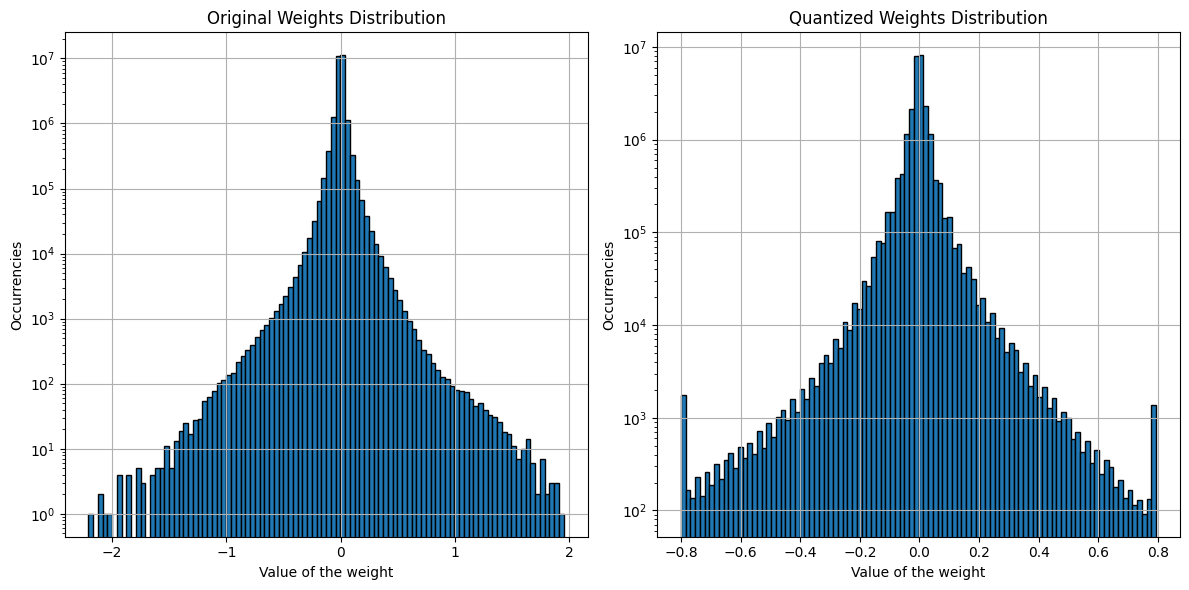

In [ ]:
import copy
def plot_weight_distribution(original_weigths, quantized_weights):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121)
    ax.hist(original_weigths, bins=100, edgecolor='black')
    ax.set_yscale("log")
    ax.set_title("Original Weights Distribution")
    ax.set_xlabel("Value of the weight")
    ax.set_ylabel("Occurrencies")
    ax.grid(True)


    # Quantized weights
    ax = fig.add_subplot(122)
    ax.hist(quantized_weights, bins=100, edgecolor='black')
    ax.set_yscale("log")
    ax.set_title("Quantized Weights Distribution")
    ax.set_xlabel("Value of the weight")
    ax.set_ylabel("Occurrencies")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

model = torch.load("full_size_model.pt")
original_weigths = torch.concatenate(
[model.fc1.weight.cpu().detach().flatten(),
 model.fc2.weight.cpu().detach().flatten(),
 model.fc3.weight.cpu().detach().flatten(),
 model.fc4.weight.cpu().detach().flatten()]).numpy()

quantize_model(model, 0.8, 8)
quantized_weights = torch.concatenate(
    [model.fc1.weight.cpu().detach().flatten(),
     model.fc2.weight.cpu().detach().flatten(),
     model.fc3.weight.cpu().detach().flatten(),
     model.fc4.weight.cpu().detach().flatten()]
    ).numpy()

plot_weight_distribution(original_weigths, quantized_weights)

Please note that the above histogram is logarithmic

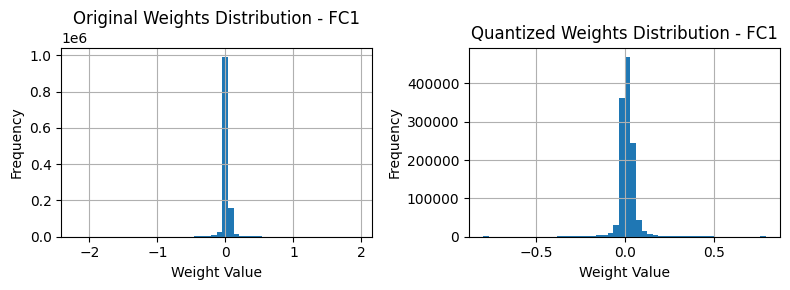

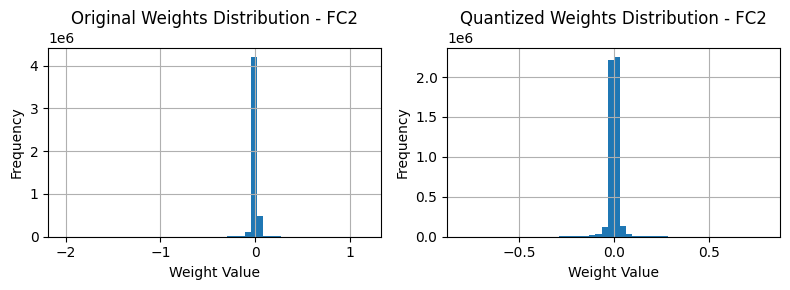

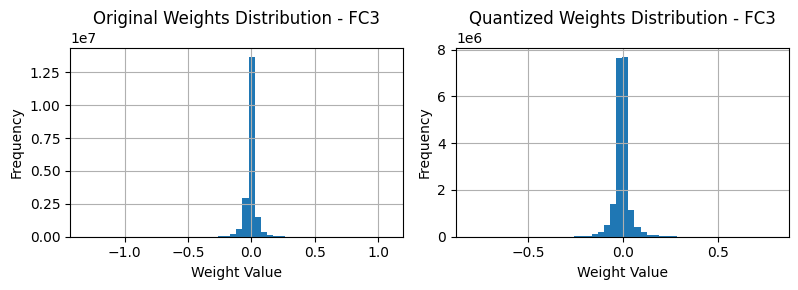

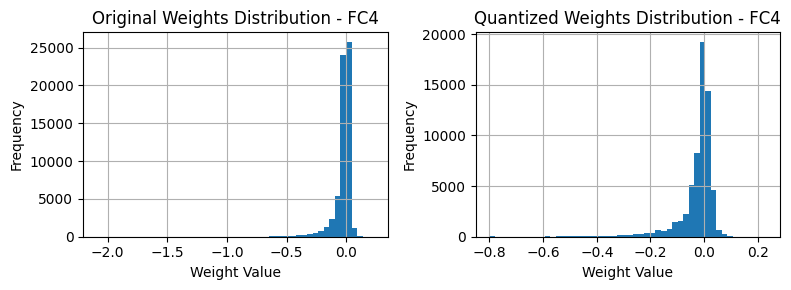

In [ ]:
def plot_weight_distribution_by_layer(original, quantized, layer_name):
    plt.figure(figsize=(8, 3))

    # Original weights
    plt.subplot(1, 2, 1)
    plt.hist(original.cpu().numpy().flatten(), bins=50)
    plt.title(f'Original Weights Distribution - {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Quantized weights
    plt.subplot(1, 2, 2)
    plt.hist(quantized.cpu().numpy().flatten(), bins=50)
    plt.title(f'Quantized Weights Distribution - {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

model = torch.load("full_size_model.pt")
weights_fc1 = model.fc1.weight.data
weights_fc2 = model.fc2.weight.data
weights_fc3 = model.fc3.weight.data
weights_fc4 = model.fc4.weight.data

quantize_model(model, 0.8, 8)
quantized_weights_fc1  = model.fc1.weight.data
quantized_weights_fc2  = model.fc2.weight.data
quantized_weights_fc3  = model.fc3.weight.data
quantized_weights_fc4  = model.fc4.weight.data

# Plot distributions for each layer
plot_weight_distribution_by_layer(weights_fc1, quantized_weights_fc1, 'FC1')
plot_weight_distribution_by_layer(weights_fc2, quantized_weights_fc2, 'FC2')
plot_weight_distribution_by_layer(weights_fc3, quantized_weights_fc3, 'FC3')
plot_weight_distribution_by_layer(weights_fc4, quantized_weights_fc4, 'FC4')


The histograms above (both the combined and individual layer versions) show distinct differences between the original and quantized weight distributions: The histogram of the original weights appears smoother, with most values concentrated around zero and gradually decreasing towards the extremes.In contrast, the quantized weights histogram is less smooth. Values are rounded to the nearest quantization step defined by the scale, resulting in distinct peaks at these quantization levels.


In summary, the plots illustrate the following effects of quantization:

- Loss of Precision: Quantization reduces the precision of weight values. Instead of a continuous range, weights are now represented at discrete levels, potentially leading to a slight loss of information.

- Peaks in Distribution: Quantized weights exhibit noticeable peaks at specific quantization levels, indicating the rounding impact of quantization.

## Structured pruning

You will use the same model as before, but this time, instead of quantizing it, you will prune it with a _structured_ approach.

### Task

Load the torch model as you did for quantization.

You need to retrieve the weight tensors and bias vectors of each layer, then prune them with the function provided below. The function applies local structured pruning using a 2-norm score.

    # get weights and biases of the first layer (you also need the second layer, as pruning the first influences the second)
    w1 = pruned_model.fc1.weight.detach()
    w2 = pruned_model.fc2.weight.detach()
    b1 = pruned_model.fc1.bias.detach()

    # prune the layer
    pruned_w1, pruned_b1, reduced_w2 = prune_layer(w1, b1, w2, p)

    # put the pruned weights and bias back in the model
    pruned_model.fc1.weight.data = pruned_w1
    pruned_model.fc1.bias.data = pruned_b1

    # proceed with the next layers... (remember to start from the reduced_w2 and not w2 for the second layer!)

Prune and test the model with different pruning ratios (you will see a decrease in performance for pruning_ratio > 0.9).

- Count the number of remaining parameters, measure the accuracy on the MNIST task and measure the inference time.
- Trace plots such as remaining parameters vs accuracy and inference time vs accuracy and comment the results.
- If you were to deploy the model on your low-resources server, what could be a good compromise?

In [ ]:
import torch

'''
    Use this function to prune a DNN layer

    You need to pass to the function the weights and bias of the layer you want to prune.

    You also need to pass to the function the weights of the next layer;
    remember that when you remove neurons from a layer, the next layer gets less inputs.

    removed_ratio is a value between 0 (no neurons removed) and 1 (all neurons removed)

    The function returns the pruned weight tensor, the pruned bias vector
    and the weight tensor of the successive layer with a reduced number of inputs.
'''

def prune_layer(weights_layer_A, bias_layer_A, weights_layer_B, pruning_ratio):
    scores = torch.norm(weights_layer_A, 2, dim=1)
    num_elements = scores.numel()
    num_to_keep = int(num_elements * pruning_ratio)
    threshold, _ = torch.kthvalue(scores, num_to_keep)
    condition = scores >= threshold
    return weights_layer_A[condition], bias_layer_A[condition], weights_layer_B[:, condition]

In [ ]:
def prune_model(model, prune_ratio):
  w1 = model.fc1.weight.detach()
  b1 = model.fc1.bias.detach()
  w2 = model.fc2.weight.detach()
  pruned_w1, pruned_b1, reduced_w2 = prune_layer(w1, b1, w2, prune_ratio)
  model.fc1.weight.data = pruned_w1
  model.fc1.bias.data = pruned_b1

  w2 = reduced_w2
  b2 = model.fc2.bias.detach()
  w3 = model.fc3.weight.detach()
  pruned_w2, pruned_b2, reduced_w3 = prune_layer(w2, b2, w3, prune_ratio)
  model.fc2.weight.data = pruned_w2
  model.fc2.bias.data = pruned_b2

  w3 = reduced_w3
  b3 = model.fc3.bias.detach()
  w4 = model.fc4.weight.detach()
  pruned_w3, pruned_b3, reduced_w4 = prune_layer(w3, b3, w4, prune_ratio)
  model.fc3.weight.data = pruned_w3
  model.fc3.bias.data = pruned_b3

  model.fc4.weight.data = reduced_w4
  return model


In [ ]:
import torch
import time
from functools import wraps

load_model = lambda: torch.load("full_size_model.pt")
count_parameters = lambda model : sum(p.numel() for p in model.parameters() if p.requires_grad)

def timing_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        return result, elapsed_time
    return wrapper

@timing_decorator
def evaluate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for i, (data, targets) in enumerate(test_loader):
          outputs = model(data)
          _, predicted = torch.max(outputs, 1)
          total += targets.size(0)
          correct += torch.sum(predicted == targets).item()

  accuracy = correct / total
  return accuracy




In [ ]:
pruning_ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.95]
num_of_params = []
accuracies = []
inference_times = []


for p in pruning_ratios:
  model = load_model()
  pruned_model = prune_model(model, p)

  accuracy, inference_time = evaluate_model(pruned_model, test_loader)
  accuracies.append(accuracy)
  inference_times.append(inference_time)
  num_of_params.append(count_parameters(pruned_model))
  print(f'Pruning ratio: {p:.2f}, Parameters: {num_of_params[-1]}, Accuracy: {100*accuracy:.4f}, Inference Time: {inference_time:.4f} seconds')



Pruning ratio: 0.20, Parameters: 16793939, Accuracy: 98.5900, Inference Time: 11.2865 seconds
Pruning ratio: 0.30, Parameters: 12976961, Accuracy: 98.5900, Inference Time: 8.3300 seconds
Pruning ratio: 0.40, Parameters: 9646059, Accuracy: 98.5900, Inference Time: 8.1421 seconds
Pruning ratio: 0.50, Parameters: 6805929, Accuracy: 98.5900, Inference Time: 6.0856 seconds
Pruning ratio: 0.60, Parameters: 4465225, Accuracy: 98.5900, Inference Time: 5.2589 seconds
Pruning ratio: 0.70, Parameters: 2610595, Accuracy: 98.5900, Inference Time: 3.8328 seconds
Pruning ratio: 0.80, Parameters: 1249889, Accuracy: 98.5200, Inference Time: 3.4611 seconds
Pruning ratio: 0.90, Parameters: 379179, Accuracy: 98.1700, Inference Time: 3.4799 seconds
Pruning ratio: 0.92, Parameters: 264250, Accuracy: 95.0000, Inference Time: 2.8568 seconds
Pruning ratio: 0.95, Parameters: 128843, Accuracy: 70.0200, Inference Time: 2.6991 seconds


In [ ]:
import matplotlib.pyplot as plt
def plot_x_y(plt, x,y, xlabel, ylabel):
  plt.plot(x, y, marker='x')
  plt.title(f'{xlabel} vs {ylabel}')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.minorticks_on()

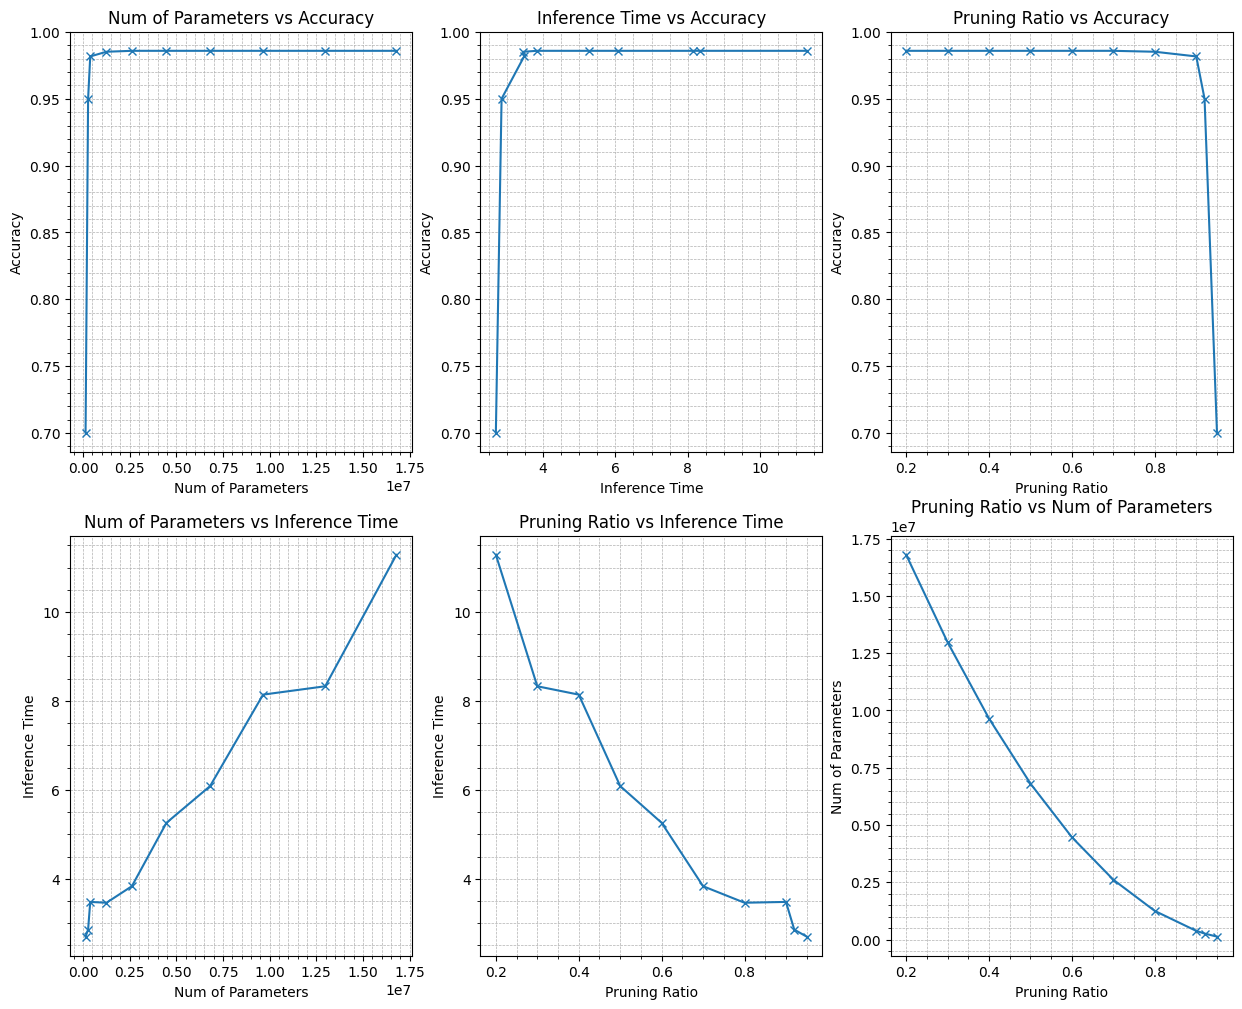

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 3, 1)
plot_x_y(plt, num_of_params,accuracies, "Num of Parameters" , "Accuracy")
plt.subplot(2, 3, 2)
plot_x_y(plt, inference_times,accuracies, "Inference Time" , "Accuracy")
plt.subplot(2, 3, 3)
plot_x_y(plt, pruning_ratios, accuracies, "Pruning Ratio" , "Accuracy")
plt.subplot(2, 3, 4)
plot_x_y(plt, num_of_params, inference_times, "Num of Parameters" , "Inference Time" )
plt.subplot(2, 3, 5)
plot_x_y(plt, pruning_ratios, inference_times, "Pruning Ratio" , "Inference Time" )
plt.subplot(2, 3, 6)
plot_x_y(plt, pruning_ratios, num_of_params, "Pruning Ratio" , "Num of Parameters" )

In [ ]:
import sys
model_size_mb = lambda model: \
  sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
model = load_model()
print(f"Model size: {model_size_mb(model):.2f} MB")
pruned_model = prune_model(model , 0.8)
print(f"Pruned Model size: {model_size_mb(pruned_model):.2f} MB")

Model size: 98.76 MB
Pruned Model size: 4.77 MB



**Accuracy vs Number of Parameters:**
As shown, the accuracy remains the same even as the number of parameters approaches approximately down to 0.3e7, indicating that additional parameters beyond this point are unnecessary for achieving good performance.

**Accuracy vs Inference Time:**
With an inference time of around 3 to 4 seconds, the model performs well. While an inference time up to 4 seconds shows no significant change in performance.

accuracy vs pruning ratio: As shown above the accuracy wont change until pruning ratio>0.7, For ratio==0.8 the accuracy slightly changes for ratio==0.9 it changes a bit but for ratio>0.9 it drops by a high marigin.

**Accuracy vs Pruning Ratio:**
Accuracy tends to decrease as more parameters are pruned, especially noticeable when the pruning ratio exceeds 0.9.
The accuracy remains the same until the pruning ratio exceeds 0.7. At a ratio of 0.8, there is a slight decrease in accuracy, and at 0.9, the decrease becomes more pronounced. Pruning ratios above 0.9 result in a significant drop in accuracy.




Deployment on Low-Resource Servers:

A good compromise for deployment on low-resource servers might be a pruning ratio that balances accuracy and resources (inference time and model size).
For example, a pruning ratio of 0.8 to 0.9 may provide a reasonable reduction in model size(98.76MB to 4.77MB) and inference time (~3 times faster) without severely compromising accuracy.